In [ ]:
# Match Source: 
# https://tianchi.aliyun.com/competition/entrance/231693/introduction?spm=5176.12281915.0.0.729310bdNbBgBC

In [14]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.max_open_warning": 0})

import seaborn as sns
import scipy.stats as ss
from _utils import u_constant
path = u_constant.PATH_ROOT + "Code projects/Python/Match/TiancChi_IndustrySteamAmountPredict_20190117/"

## 1. 数据探查

In [2]:
data_train = pd.read_table(path + "zhengqi_train.txt")
data_test = pd.read_table(path + "zhengqi_test.txt")
data_train["origin"] = "train"
data_test["origin"] = "test"
data_all = pd.concat([data_train, data_test], axis=0, ignore_index=True, sort=True)
feature_columns = [col for col in data_all.columns if col[0].upper() == "V"]  # 38  V0 - V37
feature_columns.sort(key=lambda s: int(s[1:]))
data_all.head()

V0     V1    V10    V11    V12    V13    V14    V15    V16    V17  \
0  0.566  0.016 -0.940 -0.307 -0.073  0.550 -0.484  0.000 -1.707 -1.162   
1  0.968  0.437  0.188 -0.455 -0.134  1.109 -0.488  0.000 -0.977 -1.162   
2  1.013  0.568  0.874 -0.051 -0.072  0.767 -0.493 -0.212 -0.618 -0.897   
3  0.733  0.368  0.011  0.102 -0.014  0.769 -0.371 -0.162 -0.429 -0.897   
4  0.684  0.638 -0.251  0.570  0.199 -0.349 -0.342 -0.138 -0.391 -0.897   

    ...      V36    V37     V4     V5     V6     V7     V8     V9  origin  \
0   ...   -2.608 -3.508  0.452 -0.901 -1.812 -2.360 -0.436 -2.114   train   
1   ...   -0.335 -0.730  0.194 -0.893 -1.566 -2.360  0.332 -2.114   train   
2   ...    0.765 -0.589  0.112 -0.797 -1.367 -2.360  0.396 -2.114   train   
3   ...    0.333 -0.112  0.599 -0.679 -1.200 -2.086  0.403 -2.114   train   
4   ...   -0.280 -0.028  0.337 -0.454 -1.073 -2.086  0.314 -2.114   train   

   target  
0   0.175  
1   0.676  
2   0.633  
3   0.206  
4   0.384  

[5 rows x 40 columns]

### 1.1 特征分布

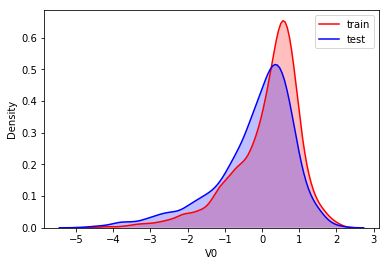

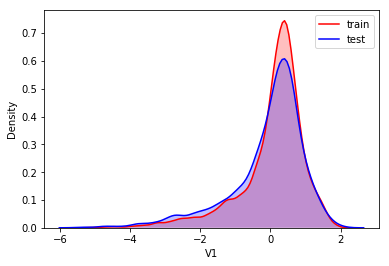

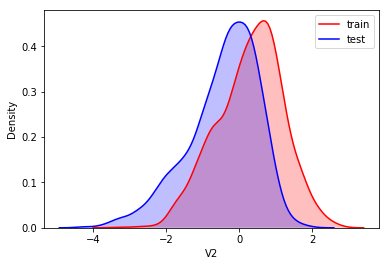

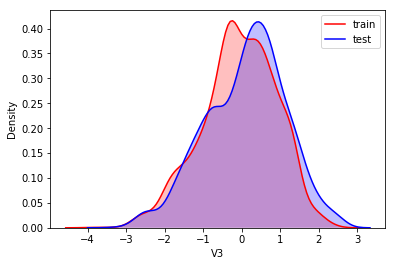

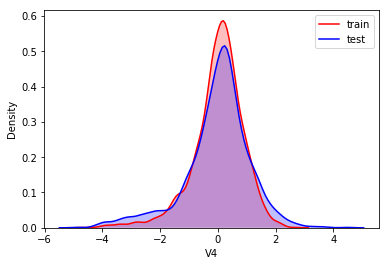

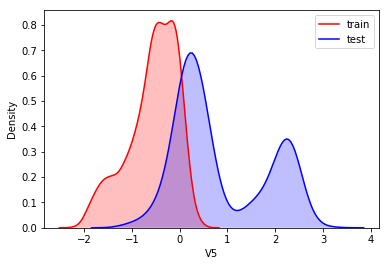

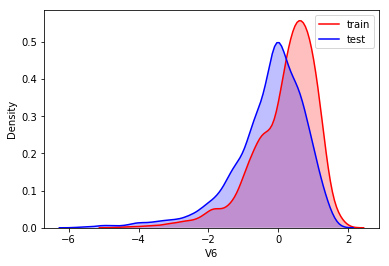

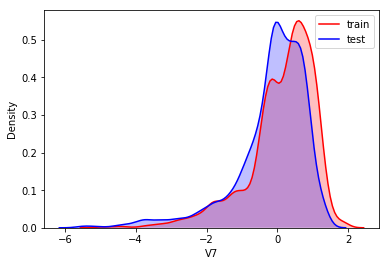

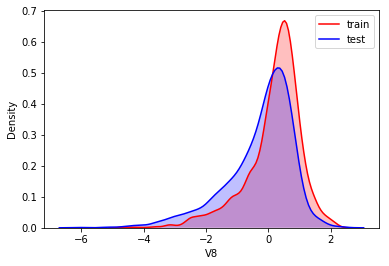

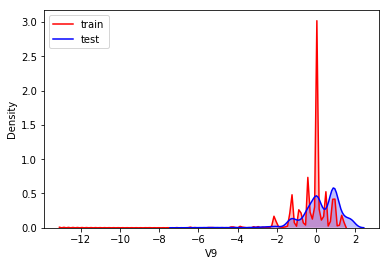

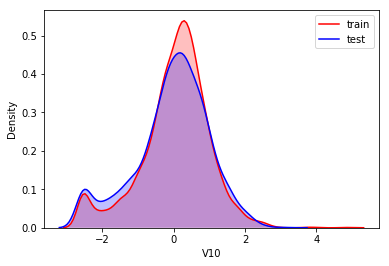

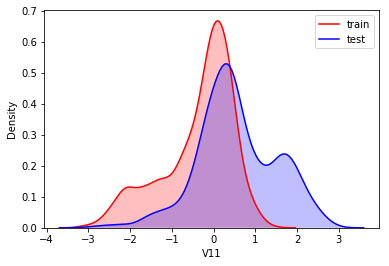

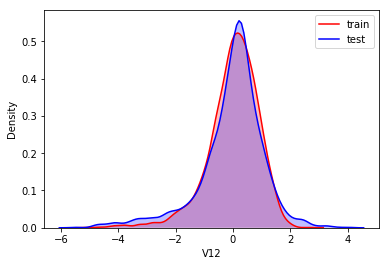

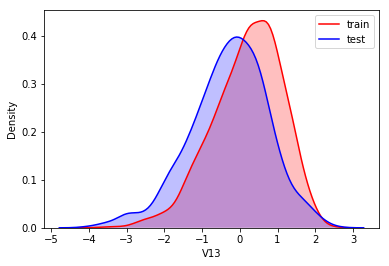

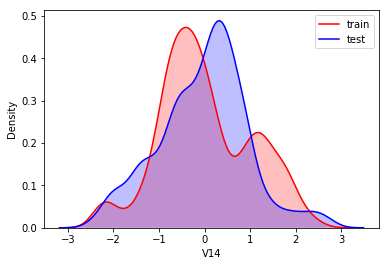

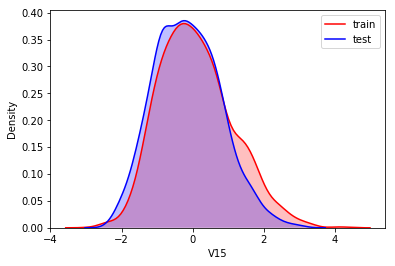

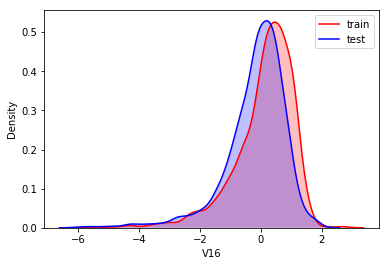

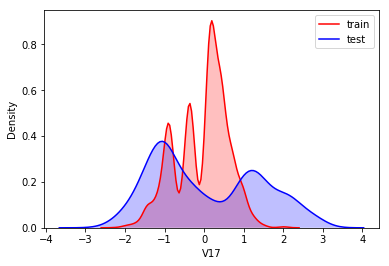

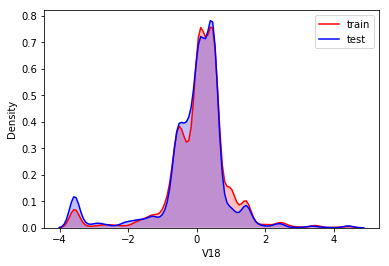

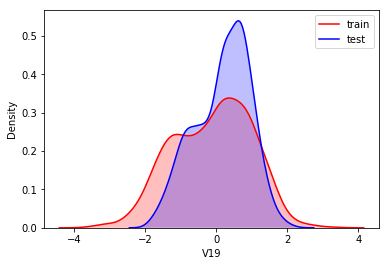

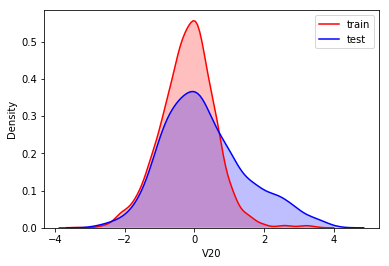

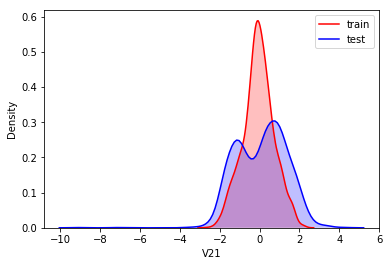

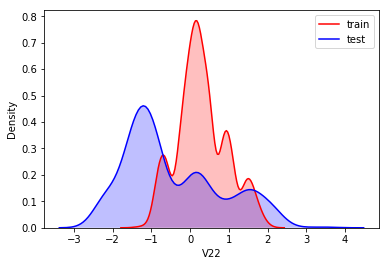

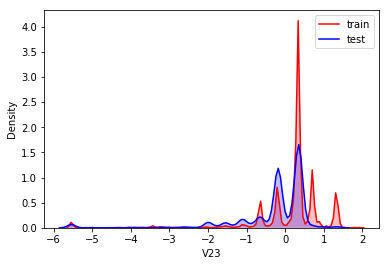

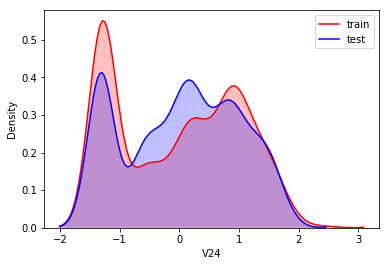

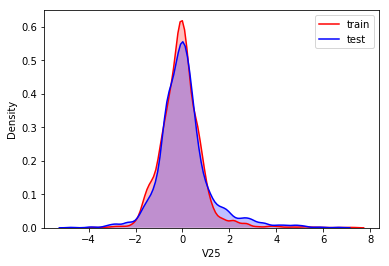

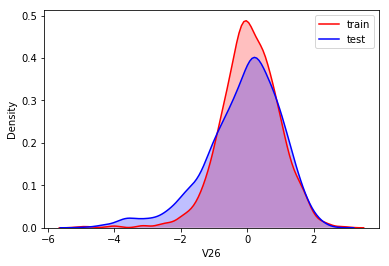

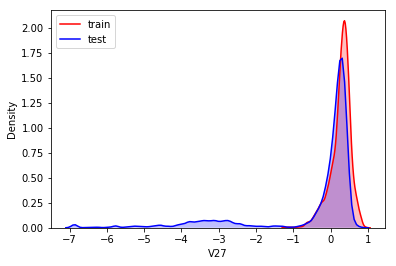

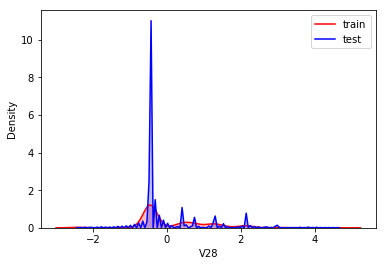

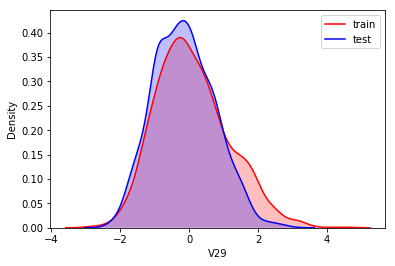

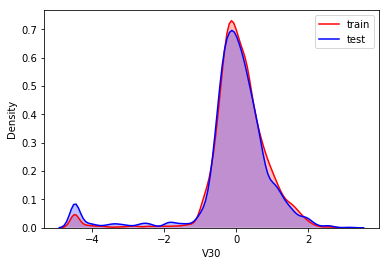

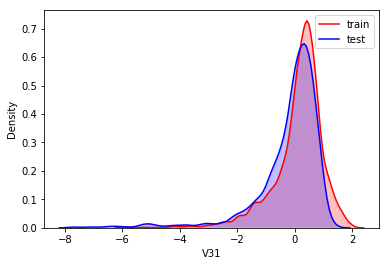

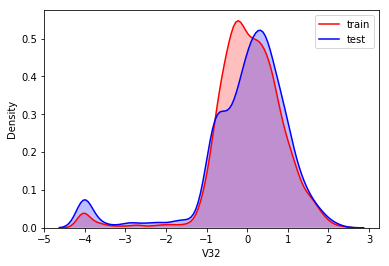

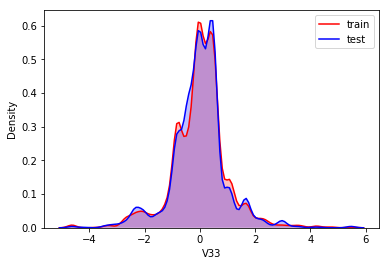

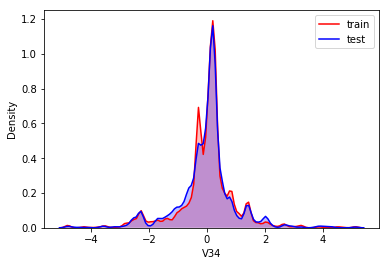

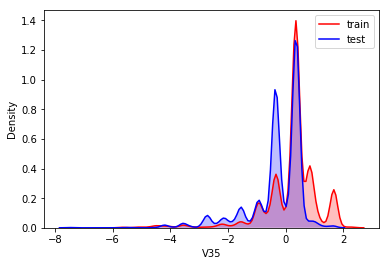

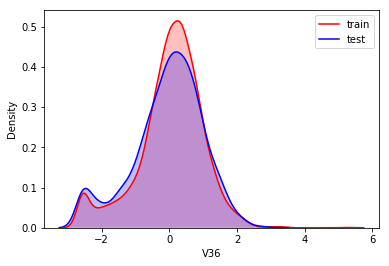

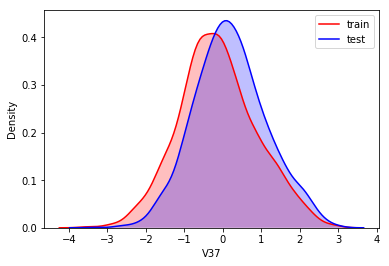

In [25]:
for column in feature_columns:
    g = sns.kdeplot(data_all.query("origin == 'train'")[column], color="red", shade=True)
    g = sns.kdeplot(data_all.query("origin == 'test'")[column], color="blue", shade=True, ax=g)
    g.set_xlabel(column)
    g.set_ylabel("Density")
    g = g.legend(["train", "test"])
    plt.show()

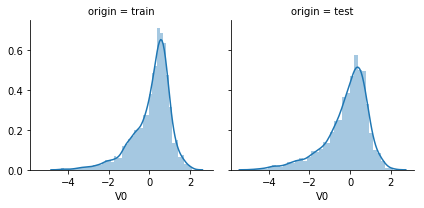

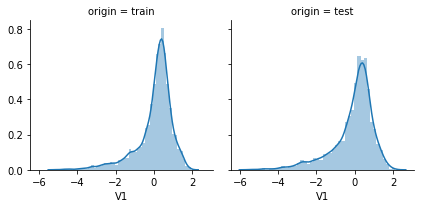

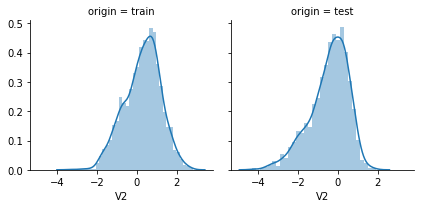

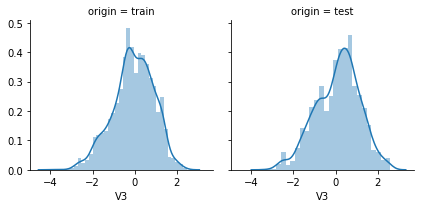

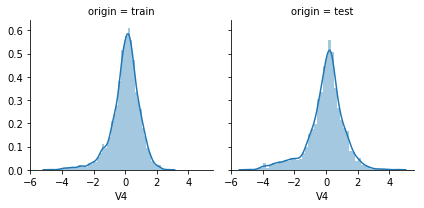

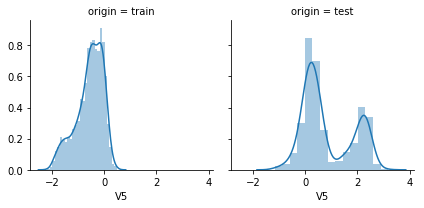

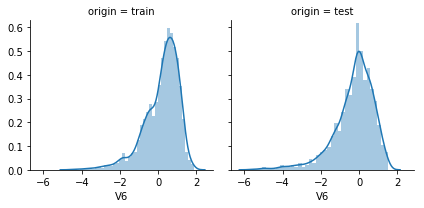

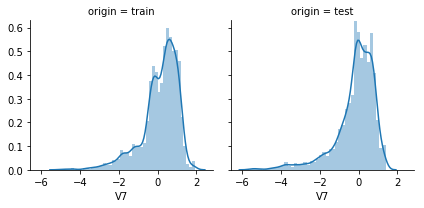

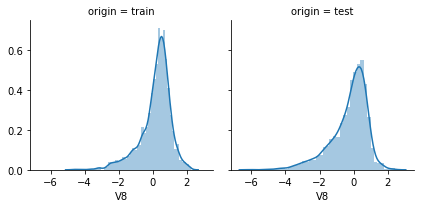

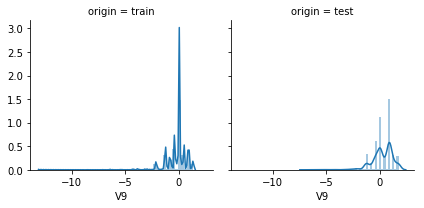

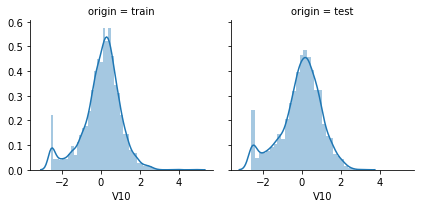

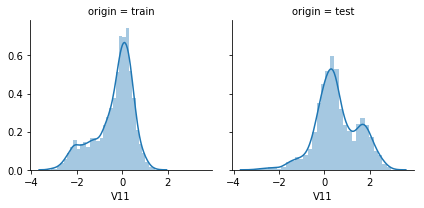

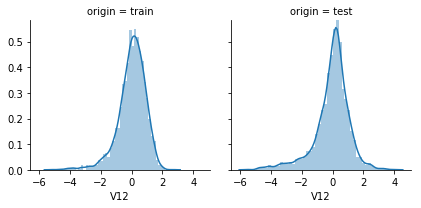

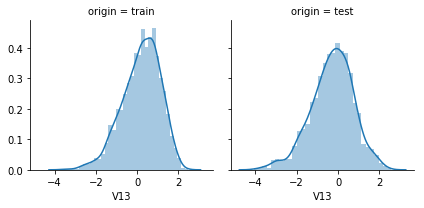

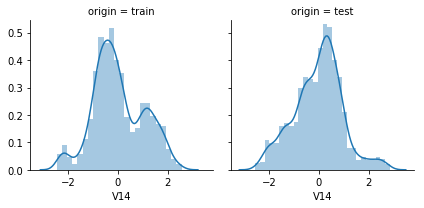

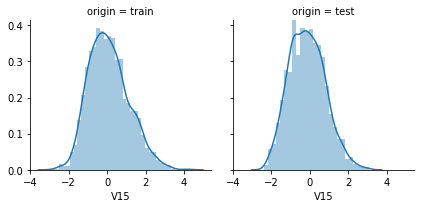

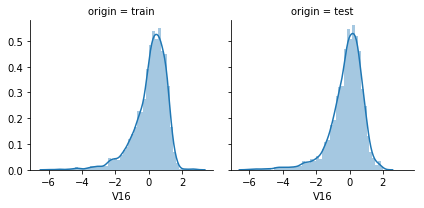

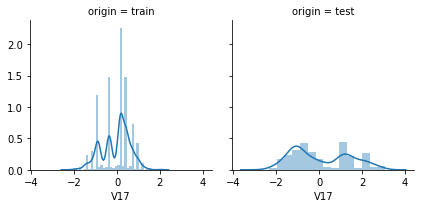

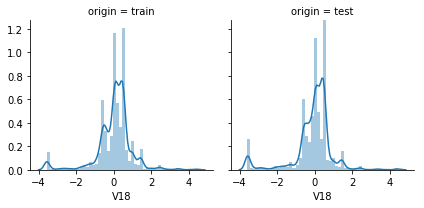

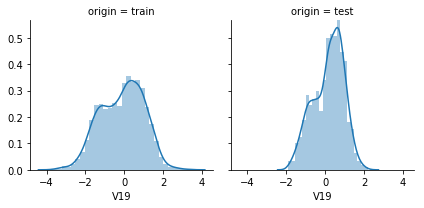

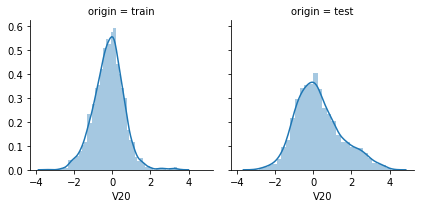

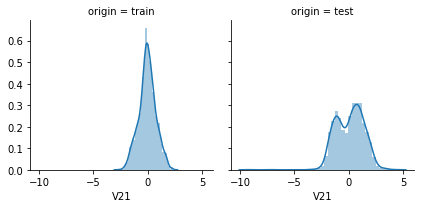

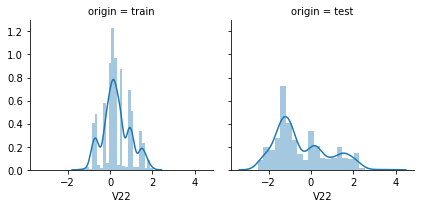

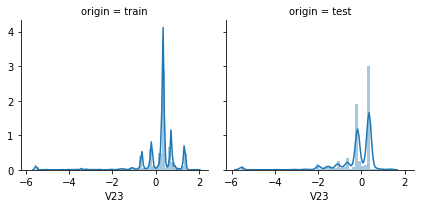

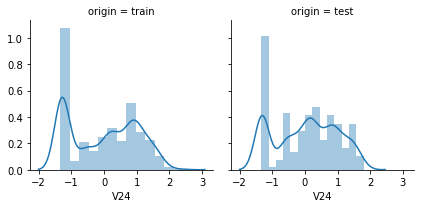

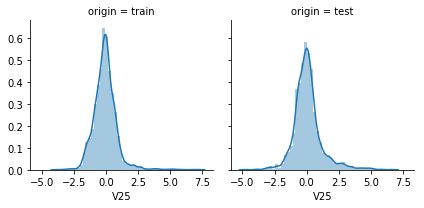

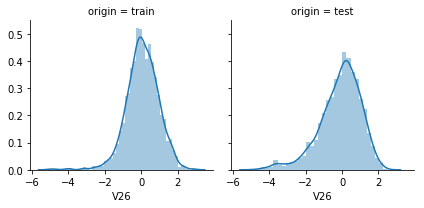

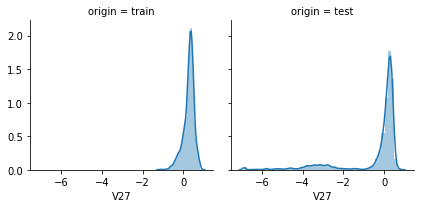

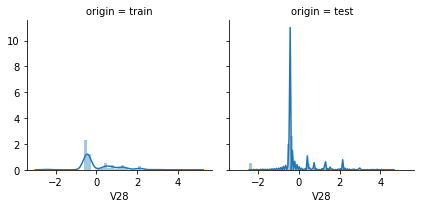

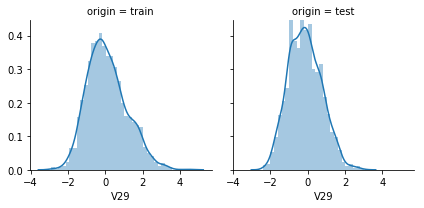

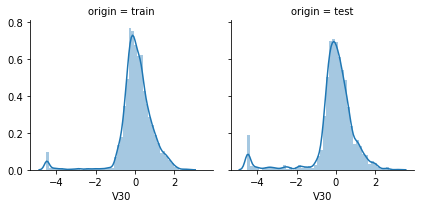

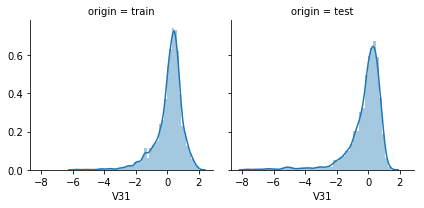

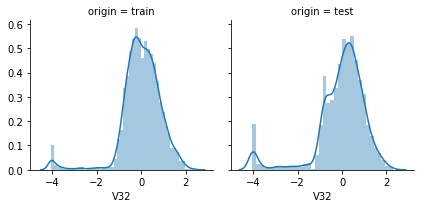

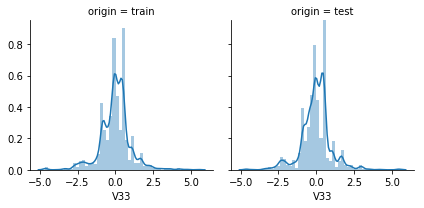

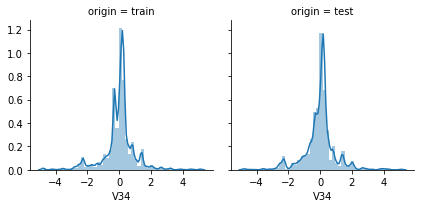

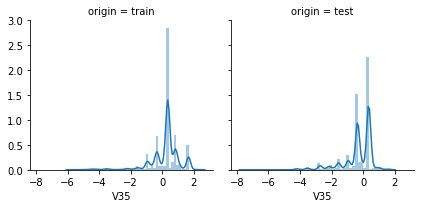

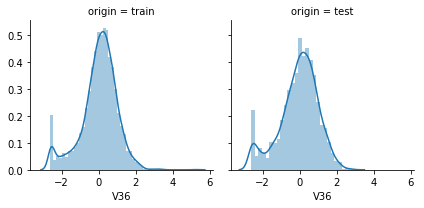

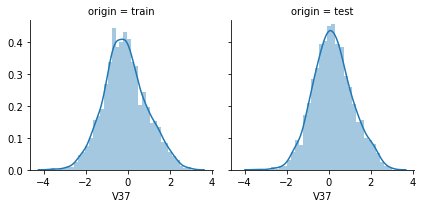

In [26]:
# Another method by facet
for column in feature_columns:
    g = sns.FacetGrid(data_all, col="origin")
    g = g.map(sns.distplot, column)

In [3]:
''' V5 V9 V11 V17 V22 V28分布不一致，删除特征 '''

data_all.drop(["V5", "V9", "V11", "V17", "V22", "V28"], axis=1, inplace=True)

### 1.2 特征相关度

In [4]:
data_train1 = data_all.query("origin == 'train'").drop("origin", axis=1)

#### 1.2.1 特征与标签的线性相关度

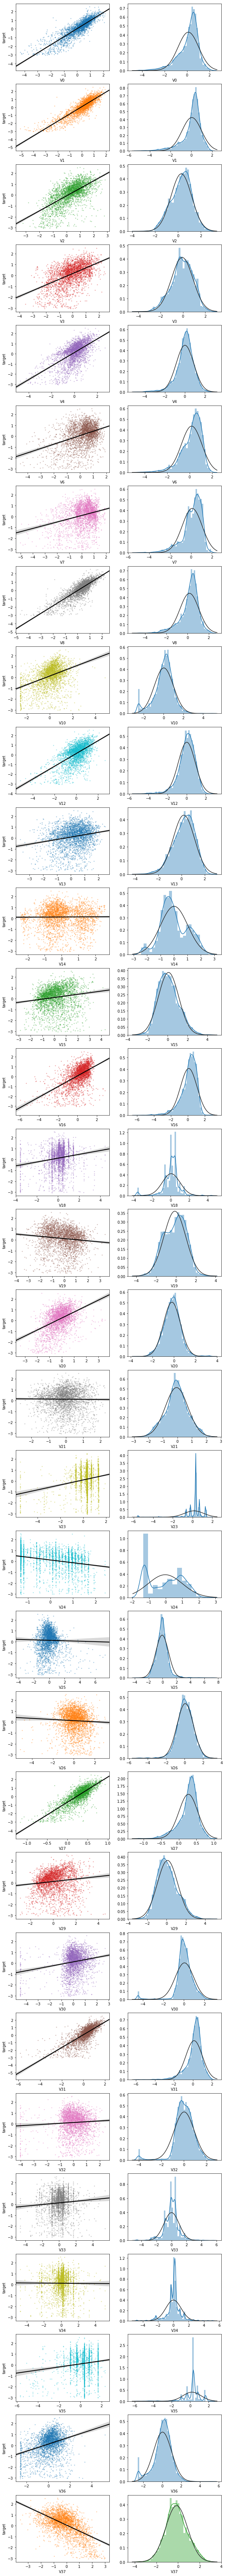

In [15]:
feature_columns = [col for col in data_train1.columns if col[0].upper() == "V"]
feature_columns.sort(key=lambda s: int(s[1:]))

ncols = 2
nrows = len(feature_columns)
figsize = (5 * ncols, 4 * nrows)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
scatter_kws = {"marker": ".", "s": 3, "alpha": 0.3}
line_kws = {"color": "k"}
for i, column in enumerate(feature_columns):
    ax = axes[i, 0]
    sns.regplot(x=column, y="target", data=data_train1, ax=ax, 
                scatter_kws=scatter_kws, line_kws=line_kws)
    ax.set_xlabel(column)
    ax.set_ylabel("target")
    
    ax = axes[i, 1]
    sns.distplot(data_train1[column], fit=ss.norm, ax=ax)
    ax.set_xlabel(column)

#### 1.2.2 特征间spearman相关度

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


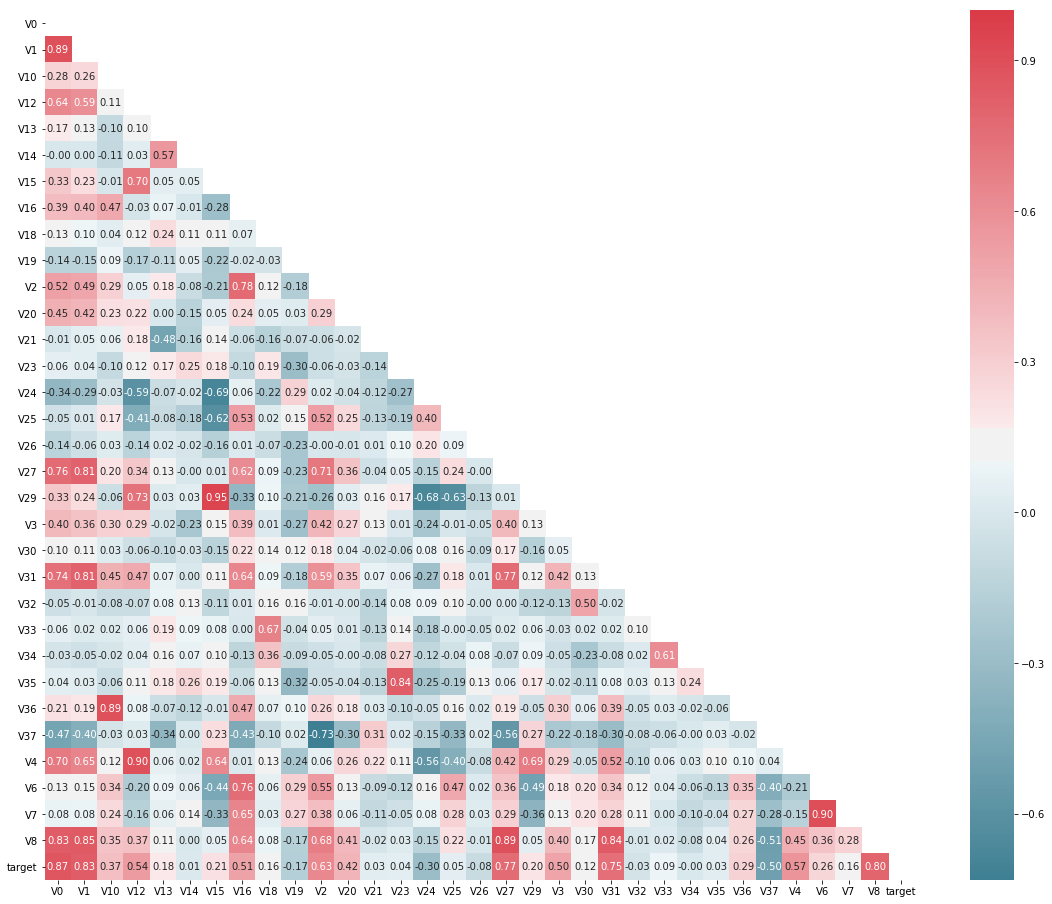

In [5]:
fig, axe = plt.subplots(figsize=(20, 16))
columns = data_train1.columns.tolist()
corr = data_train1.corr(method="spearman")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True  # 上三角（含对角）为True
cmap = sns.diverging_palette(h_neg=220, h_pos=10, as_cmap=True)  # 返回matplotlib colormap对象
g = sns.heatmap(corr, mask=mask, cmap=cmap, square=True, annot=True, fmt="0.2f", ax=axe)  # 上三角（含对角）不显示
fig.show()

In [6]:
'''去掉相关度很低的特征: 'V14', 'V21', 'V23', 'V25', 'V26', 'V32', 'V33', 'V34', 'V35' '''

threshold = 0.1
abs_corr = corr.abs()
drop_cols = abs_corr["target"][abs_corr["target"] < threshold].index.tolist()
data_all.drop(drop_cols, axis=1, inplace=True)

## 2. 特征工程

### 2.1 MinMax转换

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
feature_columns = [col for col in data_all.columns if col[0].upper() == "V"]
feature_columns.sort(key=lambda s: int(s[1:]))
ms = MinMaxScaler()
data_all[feature_columns] = ms.fit_transform(data_all[feature_columns])
data_train1 = data_all.query("origin == 'train'").drop("origin", axis=1)

In [9]:
data_all[feature_columns].describe()

V0           V1           V2           V3           V4  \
count  4813.000000  4813.000000  4813.000000  4813.000000  4813.000000   
mean      0.694172     0.721357     0.602300     0.603139     0.523743   
std       0.144198     0.131443     0.140628     0.152462     0.106430   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.626676     0.679416     0.514414     0.503888     0.478182   
50%       0.729488     0.752497     0.617072     0.614270     0.535866   
75%       0.790195     0.799553     0.700464     0.710474     0.585036   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                V6           V7           V8          V10          V12  \
count  4813.000000  4813.000000  4813.000000  4813.000000  4813.000000   
mean      0.748823     0.745740     0.715607     0.348518     0.578507   
std       0.132560     0.132577     0.118105     0.134882     0.105088   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.683324     0.696938     0.664934     0.284327     0.532892   
50%       0.774125     0.771974     0.742884     0.366469     0.591635   
75%       0.842259     0.836405     0.790835     0.432965     0.641971   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

          ...               V18          V19          V20          V24  \
count     ...       4813.000000  4813.000000  4813.000000  4813.000000   
mean      ...          0.446542     0.519158     0.456147     0.356712   
std       ...          0.124627     0.140166     0.134083     0.265512   
min       ...          0.000000     0.000000     0.000000     0.000000   
25%       ...          0.399302     0.414436     0.370475     0.040616   
50%       ...          0.456256     0.540294     0.447305     0.381736   
75%       ...          0.501745     0.623125     0.522660     0.574728   
max       ...          1.000000     1.000000     1.000000     1.000000   

               V27          V29          V30          V31          V36  \
count  4813.000000  4813.000000  4813.000000  4813.000000  4813.000000   
mean      0.881401     0.388683     0.589459     0.792709     0.332385   
std       0.128221     0.133475     0.130786     0.102976     0.127456   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.888575     0.292445     0.550092     0.761816     0.270584   
50%       0.916015     0.375734     0.594428     0.815055     0.347056   
75%       0.932555     0.471837     0.650798     0.852229     0.414861   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               V37  
count  4813.000000  
mean      0.545795  
std       0.150356  
min       0.000000  
25%       0.445647  
50%       0.539317  
75%       0.643061  
max       1.000000  

[8 rows x 23 columns]

### 2.2 BoxCox转换

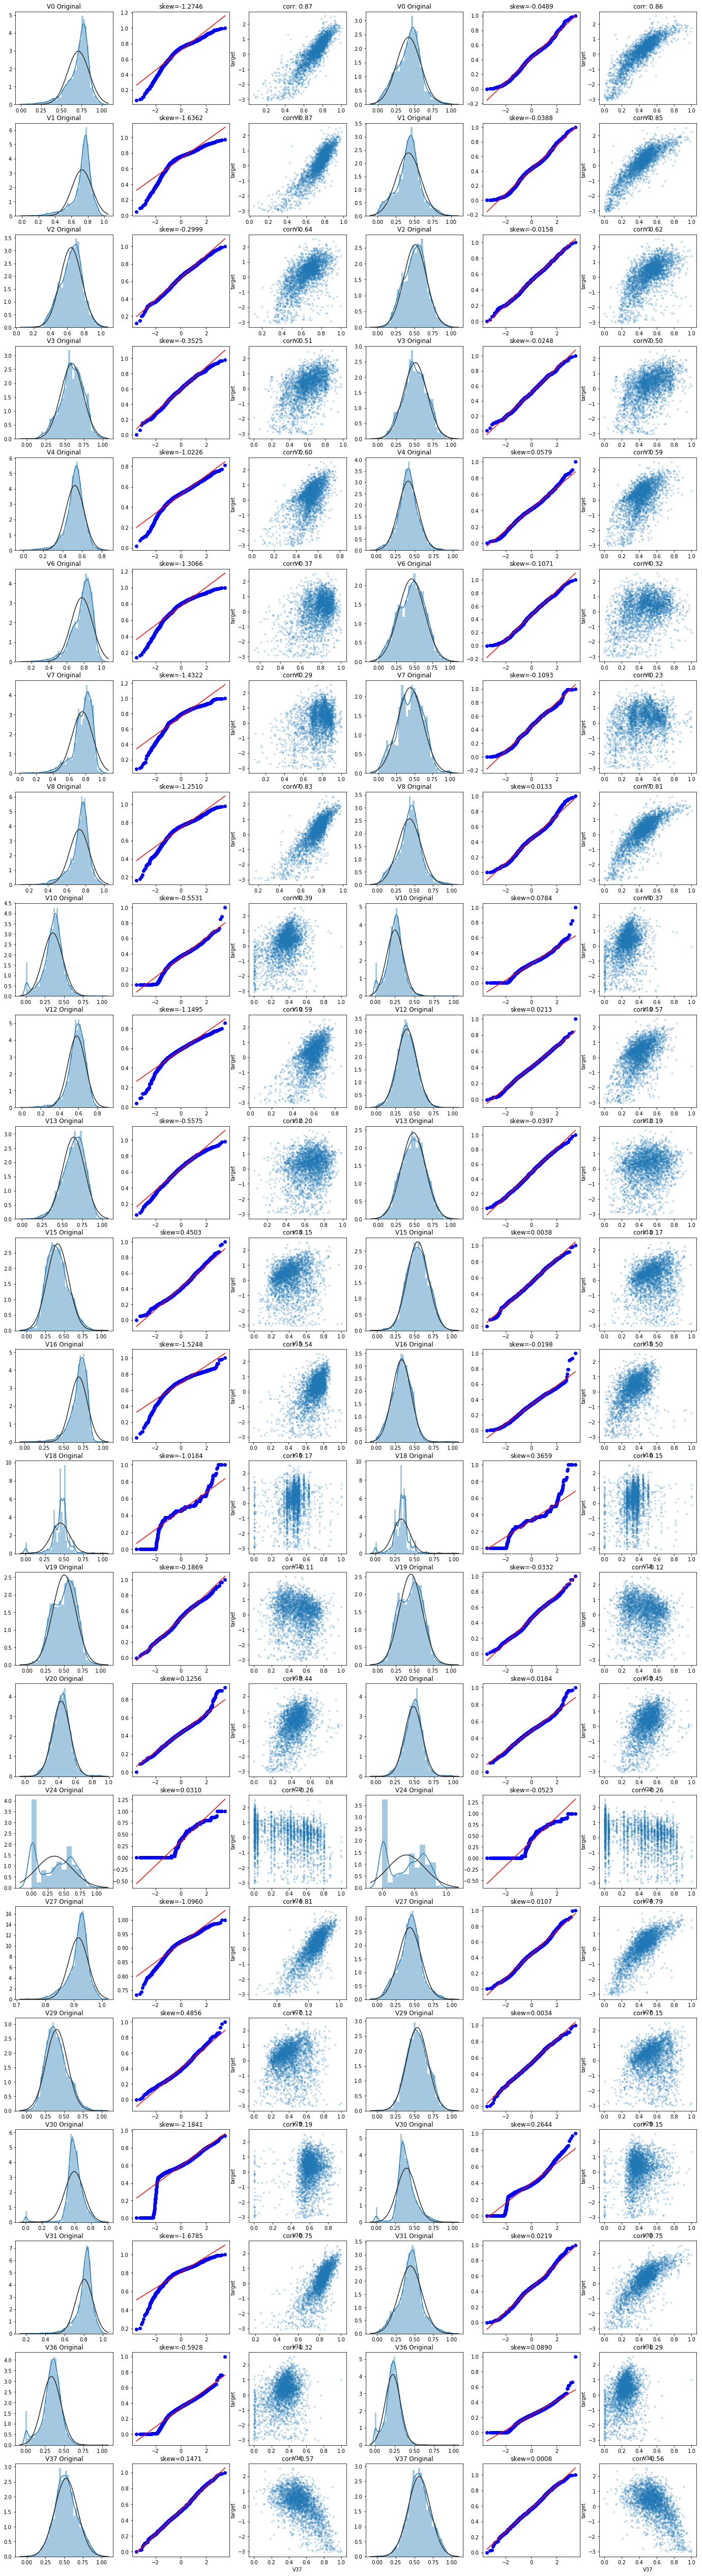

In [60]:
''' Check effect of Box-Cox transforms on distributions of continuous variables '''

ncols = 6
nrows = len(feature_columns)
figsize = (4 * ncols, 4 * nrows)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
target = data_train1["target"].values

def dist_plot(column, var, ax):
    sns.distplot(var, fit=ss.norm, ax=ax)
    ax.set_title(column + " Original")
    ax.set_xlabel("")

def qq_plot(column, var, ax):
    ss.probplot(var, plot=ax)
    ax.set_title("skew=%.4f" % (ss.skew(var)))
    ax.set_xlabel("")
    ax.set_ylabel("")

def scatter_plot(column, var, ax):
    ax.scatter(x=var, y=target, marker=".", alpha=0.2)
    ax.set_title("corr: %.2f" % (np.corrcoef(var, target)[0][1]))
    ax.set_xlabel(column)
    ax.set_ylabel("target")

for i, column in enumerate(feature_columns):
    var = data_train1[column].values
    trans_var, lambda_var = ss.boxcox(var + 1)
    trans_var = ms.fit_transform(trans_var.reshape(-1, 1)).flatten()    
    
    # 柱状 + kde分布图
    ax = axes[i, 0]
    dist_plot(column, var, ax)
    
    # QQ图
    ax = axes[i, 1]
    qq_plot(column, var, ax)
    
    # 散点图
    ax = axes[i, 2]
    scatter_plot(column, var, ax)
    
    # BoxCox转换后的 柱状 + kde分布图
    ax = axes[i, 3]
    dist_plot(column, trans_var, ax)
    
    # BoxCox转换后的 QQ图
    ax = axes[i, 4]
    qq_plot(column, trans_var, ax)
    
    # BoxCox转换后的 散点图
    ax = axes[i, 5]
    scatter_plot(column, trans_var, ax)

In [10]:
'''转换效果不错，可以看到很多特征正态性明显变好了。对整体进行boxcox处理'''
for column in feature_columns:
    data_all[column], _ = ss.boxcox(data_all[column] + 1)

### 2.3 Label处理

In [23]:
data_train1 = data_all.query("origin == 'train'").drop("origin", axis=1)
target = data_train1["target"].values
print(data_train1["target"].describe())

count    2888.000000
mean        0.126353
std         0.983966
min        -3.044000
25%        -0.350250
50%         0.313000
75%         0.793250
max         2.538000
Name: target, dtype: float64


In [15]:
def eda_label(target):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    sns.distplot(target, fit=ss.norm, ax=axes[0])
    ss.probplot(target, plot=axes[1])
    fig.show()

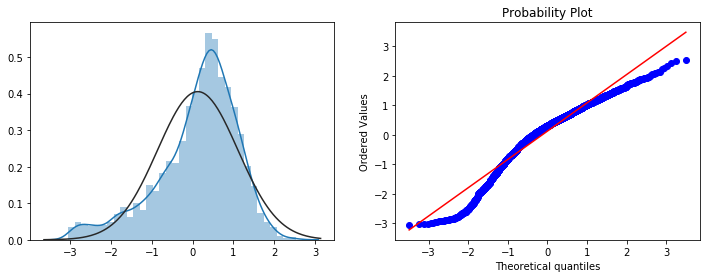

In [16]:
eda_label(target)

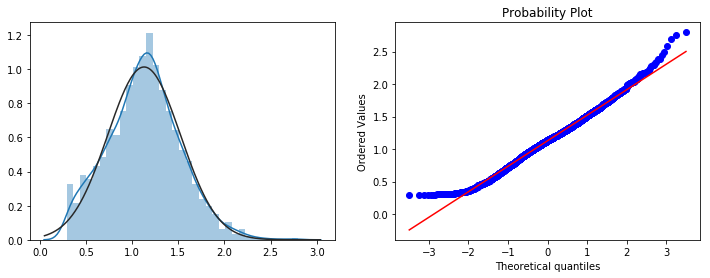

In [17]:
'''Label的正态性不佳，略微右偏'''
'''指数转换'''
eda_label(np.power(1.5, target))  # 指数底为1.5

In [24]:
data_train1["target1"] = np.power(1.5, data_train1["target"])

## 3. 样本处理

### 3.1 样本切割

In [26]:
from sklearn.model_selection import train_test_split

In [32]:
feature_columns = [col for col in data_train1.columns if col[0] == "V"]
target_column = "target1"
X = data_train1[feature_columns].values
y = data_train1[target_column].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=100)

X_test = data_all.query("origin == 'test'")[feature_columns].values

### 3.2 离群点去除

In [39]:
from sklearn.linear_model import Ridge

In [42]:
def omit_outliers(model, X, y, thresh=3):
    # predict y values by model
    try:
        y_pred = model.predict(X)
    except AttributeError:
        model.fit(X, y)
        y_pred = model.predict(X)
    
    # Analyse residuals
    res = y - y_pred
    mean = np.mean(res)
    std = np.std(res)
    
    # Omit outliers based on Norm distribution
    z = np.abs((res - mean) / std)
    keep = (z <= thresh)
    omit_X = X[keep]
    omit_y = y[keep]
    print("Omit %d Outliers" % (sum(~keep)))
    return omit_X, omit_y
    

In [43]:
X_t, y_t = omit_outliers(Ridge(), X_train, y_train)

Omit 24 Outliers


## 4. 模型训练

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

In [59]:
N_SPLITS = 5
N_REPEATS = 5
opt_models = {}

In [69]:
def train_model(model, X, y, param_grid={}, n_splits=5, n_repeats=5):
    rkfold = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
    if len(param_grid) > 0:
        gs = GridSearchCV(estimator=model, 
                          cv=rkfold,
                          param_grid=param_grid, 
                          scoring="neg_mean_squared_error", 
                          verbose=1, 
                          return_train_score=True)
        gs.fit(X, y)
        model = gs.best_estimator_
        best_idx = gs.best_index_
        grid_results = pd.DataFrame(gs.cv_results_)
        cv_mean = np.abs(grid_results.loc[best_idx, "mean_test_score"])
        cv_std = grid_results.loc[best_idx, "std_test_score"]
    else:
        grid_results = []
        cv_results = cross_val_score(estimator=model, X=X, y=y, scoring="neg_mean_squared_error")
        cv_mean = np.abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    cv_score = {"mean": cv_mean, "std": cv_std}
    return model, cv_score, grid_results

def grid_result_plot(var, grid_results, cv_num):
    fig, axe = plt.subplots(1, 1, figsize=(8, 8))
    axe.errorbar(x=var, 
                 y=abs(grid_results["mean_test_score"]), 
                 yerr=abs(grid_results["std_test_score"]) / np.sqrt(cv_num))
    axe.set_xlabel("variable")
    axe.set_ylabel("score")
    fig.show()

## 4.1 Ridge模型

In [63]:
model = "Ridge"
param_grid = {"alpha": np.arange(0.25, 6, 0.25)}
opt_models[model], cv_score, grid_results = train_model(Ridge(), X_t, y_t, param_grid, 
                                                        n_splits=N_SPLITS, n_repeats=N_REPEATS)


Fitting 25 folds for each of 23 candidates, totalling 575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 575 out of 575 | elapsed:    0.9s finished


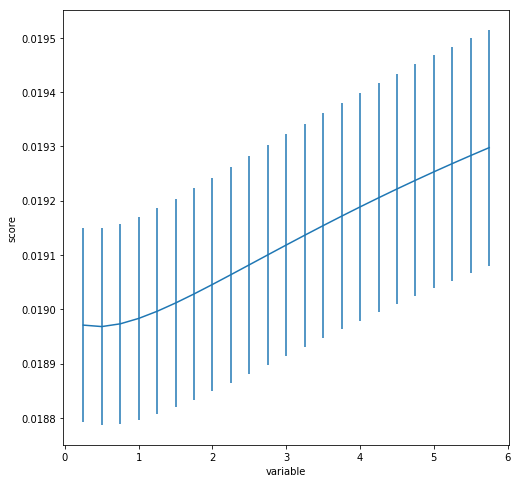

In [70]:
grid_result_plot(param_grid["alpha"], grid_results, N_REPEATS * N_SPLITS)

In [ ]:
GridSearchCV()